In [2]:
import sys
from pathlib import Path
sys.path.insert(0,str(Path.cwd().parent))
from package import *
from datetime import datetime
from package.DandjooId import DandjooId
from shapely.geometry import MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import socket
from dateutil import parser
from datetime import datetime
from pyproj import Proj, transform
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth',None)

QUALITY ASSURANCE CHECK ON BIRD MASTER DATA

Step 1) User specifies path to file in blob store container, file read as dataframe.

In [3]:
# Define containers: 010-recieved, 015-recieved, record deltas
creds: pd.DataFrame = pd.read_csv('credential.csv',dtype=str, index_col='item')
cred: str = creds.loc['cred','value']

a10_recieved: str = creds.loc['10_recieved','value']
a15_extracted: str = creds.loc['15_extracted','value']
a20_tabular: str = creds.loc['20_tabular','value']
a25_preprocessed: str = creds.loc['25_preprocessed','value']
a30_ingestion: str = creds.loc['30_ingestion','value']

a10_recieved: ContainerClient = ContainerClient.from_container_url(a10_recieved, cred)
a15_extracted: ContainerClient = ContainerClient.from_container_url(a15_extracted, cred)
a20_tabular: ContainerClient = ContainerClient.from_container_url(a20_tabular, cred)
a25_preprocessed: ContainerClient = ContainerClient.from_container_url(a25_preprocessed, cred)
a30_ingestion: ContainerClient = ContainerClient.from_container_url(a30_ingestion, cred)

# Define file paramaters - the path of the file in the blobstore.
infile: Path = Path('AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx')
parent: Path = infile.parent
filename: str = infile.name.removesuffix(infile.suffix).lower().replace('.','')
filename = '_'.join(filename.split())
targetp: Path = parent / f'{filename}.csv'
partdir: Path = parent / filename
logpath: Path = partdir / f'{filename}_log.csv'
invpath: Path = partdir / f'{filename}_invalid.csv'

eventlog: pd.DataFrame = pd.DataFrame(columns=['event_id','datetime','user','description'])
message, af = read_df(a15_extracted, infile)
af.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,DATE,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,NO OF ==>,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,COUNT,DAY,MONTH,YEAR,OBSERVER CODE,OBSERVER NAMES,RAOU,COMMON NAME [WAM],SCIENTIFIC NAME [WAM],WIND SPEED,CLOUD COVER (%),HOUR [TIME START],MINUTE [TIME START],HOUR [TIME FINISH],MINUTE [TIME FINISH],MALE,FEMALE,ADULT,JUVENILE,UNKNOWN,TOTAL,OUT OF AREA? [YES or NO],PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central Peg W2.3,GDA94 NORTHING Central Peg W2.3,GDA94 EASTING Corner Peg W1.2,GDA94 NORTHING Corner Peg W1.2,GDA94 EASTING Corner Peg W1.4,GDA94 NORTHING Corner Peg W1.4,GDA94 EASTING Corner Peg W3.2,GDA94 NORTHING Corner Peg W3.2,GDA94 EASTING Corner Peg W3.4,GDA94 NORTHING Corner Peg W3.4
1,1,SV1-1,1,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,398,Western Whistler,Pachycephala fuliginosa,0,100,6,0,6,20,1,0,0,0,0,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
2,2,SV1-2,2,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,976,Striated Paradalote,Pardalotus striatus,0,100,6,0,6,20,0,0,0,0,2,2,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
3,3,SV1-3,3,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,266,Baudin's Cockatoo,Calyptorhynchus baudinii,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
4,4,SV1-4,4,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,408,Grey Shrikethrush,Colluricincla harmonica,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002


Logged error while reading file

In [4]:
logevent(description=f'errors when reading file "{str(infile)}" : {message}',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JTQQf1950e84,2024-09-19T16:16:31.103709,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" : N/A"


Set the first row (row's numbering 0) in 'af' DataFrame,  as the new header

In [5]:
aff: pd.DataFrame = af.copy(deep=True)  # Make a copy of the original DataFrame (af) so that changes to aff doesn't affect af

aff.columns = aff.iloc[0]  # Set the first row's as the new header

# Drop the first row, since it's now the header. I.e, since the row 0's from the af dataframe has become the new header, use the next row (ie row 1 in af) as the first row in aff dataframe
aff = aff[1:]

# Reset the index to ensure a clean DataFrame
aff.reset_index(drop=True, inplace=True)

# Display the final DataFrame
aff.head()

# Optional, get the new column names
#aff.columns


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,COUNT,DAY,MONTH,YEAR,OBSERVER CODE,OBSERVER NAMES,RAOU,COMMON NAME [WAM],SCIENTIFIC NAME [WAM],WIND SPEED,CLOUD COVER (%),HOUR [TIME START],MINUTE [TIME START],HOUR [TIME FINISH],MINUTE [TIME FINISH],MALE,FEMALE,ADULT,JUVENILE,UNKNOWN,TOTAL,OUT OF AREA? [YES or NO],PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central Peg W2.3,GDA94 NORTHING Central Peg W2.3,GDA94 EASTING Corner Peg W1.2,GDA94 NORTHING Corner Peg W1.2,GDA94 EASTING Corner Peg W1.4,GDA94 NORTHING Corner Peg W1.4,GDA94 EASTING Corner Peg W3.2,GDA94 NORTHING Corner Peg W3.2,GDA94 EASTING Corner Peg W3.4,GDA94 NORTHING Corner Peg W3.4
0,1,SV1-1,1,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,398,Western Whistler,Pachycephala fuliginosa,0,100,6,0,6,20,1,0,0,0,0,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
1,2,SV1-2,2,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,976,Striated Paradalote,Pardalotus striatus,0,100,6,0,6,20,0,0,0,0,2,2,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
2,3,SV1-3,3,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,266,Baudin's Cockatoo,Calyptorhynchus baudinii,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
3,4,SV1-4,4,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,408,Grey Shrikethrush,Colluricincla harmonica,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
4,5,SV1-5,5,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,338,Fan-tailed Cuckoo,Cacomantis flabelliformis,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002


Renaming some complex column names into a simple name

In [6]:
def rename_columns(df, columns_dict):
    """
    Rename columns in a Dataframe.

    Parameters:
    df(pd.DataFrame): The DataFrame whose columns need to be renamed.
    columns_dict(dict): A dictionary where keys are old column names and values are new column names.

    Returns:
    pd.DataFrame: DataFrame with renamed columns.
    """
    df.rename(columns=columns_dict, inplace=True)
    return df

# Renaming columns
new_columns = {'SCIENTIFIC NAME [WAM]':'SCIENTIFIC NAME', 'GDA94 EASTING Central Peg W2.3': 'GDA94 EASTING Central', 'GDA94 NORTHING Central Peg W2.3': 'GDA94 NORTHING Central'}
aff = rename_columns(aff, new_columns)
aff.head()

,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,COUNT,DAY,MONTH,YEAR,OBSERVER CODE,OBSERVER NAMES,RAOU,COMMON NAME [WAM],SCIENTIFIC NAME,WIND SPEED,CLOUD COVER (%),HOUR [TIME START],MINUTE [TIME START],HOUR [TIME FINISH],MINUTE [TIME FINISH],MALE,FEMALE,ADULT,JUVENILE,UNKNOWN,TOTAL,OUT OF AREA? [YES or NO],PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,GDA94 EASTING Corner Peg W1.2,GDA94 NORTHING Corner Peg W1.2,GDA94 EASTING Corner Peg W1.4,GDA94 NORTHING Corner Peg W1.4,GDA94 EASTING Corner Peg W3.2,GDA94 NORTHING Corner Peg W3.2,GDA94 EASTING Corner Peg W3.4,GDA94 NORTHING Corner Peg W3.4
0,1,SV1-1,1,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,398,Western Whistler,Pachycephala fuliginosa,0,100,6,0,6,20,1,0,0,0,0,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
1,2,SV1-2,2,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,976,Striated Paradalote,Pardalotus striatus,0,100,6,0,6,20,0,0,0,0,2,2,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
2,3,SV1-3,3,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,266,Baudin's Cockatoo,Calyptorhynchus baudinii,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
3,4,SV1-4,4,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,408,Grey Shrikethrush,Colluricincla harmonica,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002
4,5,SV1-5,5,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,338,Fan-tailed Cuckoo,Cacomantis flabelliformis,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002


Convert the location data ('GDA94 EASTING Central' and 'GDA94 NORTHING Central') to Longitude and Latitude

In [7]:
# Define projections using EPSG codes
gda94 = Proj('epsg:28350')  # GDA94 
wgs84 = Proj('epsg:4326')   # WGS84

# Function to convert coordinates
def convert_to_latlon(easting, northing):
    lat, lon = transform(gda94, wgs84, easting, northing)
    return lat, lon

# Apply conversion by calling the function
aff['Latitude'], aff['Longitude'] = zip(*aff.apply(lambda row: convert_to_latlon(row['GDA94 EASTING Central'], row['GDA94 NORTHING Central']), axis=1))

aff.head()

/tmp/ipykernel_145166/1575176851.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lat, lon = transform(gda94, wgs84, easting, northing)


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,COUNT,DAY,MONTH,YEAR,OBSERVER CODE,OBSERVER NAMES,RAOU,COMMON NAME [WAM],SCIENTIFIC NAME,WIND SPEED,CLOUD COVER (%),HOUR [TIME START],MINUTE [TIME START],HOUR [TIME FINISH],MINUTE [TIME FINISH],MALE,FEMALE,ADULT,JUVENILE,UNKNOWN,TOTAL,OUT OF AREA? [YES or NO],PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,GDA94 EASTING Corner Peg W1.2,GDA94 NORTHING Corner Peg W1.2,GDA94 EASTING Corner Peg W1.4,GDA94 NORTHING Corner Peg W1.4,GDA94 EASTING Corner Peg W3.2,GDA94 NORTHING Corner Peg W3.2,GDA94 EASTING Corner Peg W3.4,GDA94 NORTHING Corner Peg W3.4,Latitude,Longitude
0,1,SV1-1,1,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,398,Western Whistler,Pachycephala fuliginosa,0,100,6,0,6,20,1,0,0,0,0,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491
1,2,SV1-2,2,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,976,Striated Paradalote,Pardalotus striatus,0,100,6,0,6,20,0,0,0,0,2,2,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491
2,3,SV1-3,3,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,266,Baudin's Cockatoo,Calyptorhynchus baudinii,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491
3,4,SV1-4,4,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,408,Grey Shrikethrush,Colluricincla harmonica,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491
4,5,SV1-5,5,2001,SPRING,1,23,10,2001,1,Graeme LIDDELOW,338,Fan-tailed Cuckoo,Cacomantis flabelliformis,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491


Concartenate the 'YEAR', 'MONTH' and 'DAY' column in 'aff' DataFrame to a new column called 'DATE'

In [8]:
# Create a new variable for the aff dataframe above
af1: pd.DataFrame = aff.copy(deep=True)

# Ensure column names are correct
af1.columns = af1.columns.str.strip()

# Drop any duplicate column (ie select only columns that are not duplicate(~))
af1 = af1.loc[:, ~af1.columns.duplicated()]

# Create 'DATE' column, and ensure that invalid 'DATES' are converted to NAN (Using the function, errors='coerce')
af1['DATE'] = pd.to_datetime(af1[['YEAR','MONTH','DAY']], errors='coerce')

# Drop rows where 'DATE' is NAN or Not a time
#af1 = af1.dropna(subset=['DATE'])

af1.head()


,TOTAL RECORD NO,SURVEY RECORD NO,RECORD NO,YEAR,SEASON,COUNT,DAY,MONTH,OBSERVER CODE,OBSERVER NAMES,RAOU,COMMON NAME [WAM],SCIENTIFIC NAME,WIND SPEED,CLOUD COVER (%),HOUR [TIME START],MINUTE [TIME START],HOUR [TIME FINISH],MINUTE [TIME FINISH],MALE,FEMALE,ADULT,JUVENILE,UNKNOWN,TOTAL,OUT OF AREA? [YES or NO],PLOT NO,GRID PREFIX,LOCATION,TREATMENT,FIRE TREATMENT,GDA94 EASTING Central,GDA94 NORTHING Central,GDA94 EASTING Corner Peg W1.2,GDA94 NORTHING Corner Peg W1.2,GDA94 EASTING Corner Peg W1.4,GDA94 NORTHING Corner Peg W1.4,GDA94 EASTING Corner Peg W3.2,GDA94 NORTHING Corner Peg W3.2,GDA94 EASTING Corner Peg W3.4,GDA94 NORTHING Corner Peg W3.4,Latitude,Longitude,DATE
0,1,SV1-1,1,2001,SPRING,1,23,10,1,Graeme LIDDELOW,398,Western Whistler,Pachycephala fuliginosa,0,100,6,0,6,20,1,0,0,0,0,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491,2001-10-23
1,2,SV1-2,2,2001,SPRING,1,23,10,1,Graeme LIDDELOW,976,Striated Paradalote,Pardalotus striatus,0,100,6,0,6,20,0,0,0,0,2,2,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491,2001-10-23
2,3,SV1-3,3,2001,SPRING,1,23,10,1,Graeme LIDDELOW,266,Baudin's Cockatoo,Calyptorhynchus baudinii,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491,2001-10-23
3,4,SV1-4,4,2001,SPRING,1,23,10,1,Graeme LIDDELOW,408,Grey Shrikethrush,Colluricincla harmonica,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491,2001-10-23
4,5,SV1-5,5,2001,SPRING,1,23,10,1,Graeme LIDDELOW,338,Fan-tailed Cuckoo,Cacomantis flabelliformis,0,100,6,0,6,20,0,0,0,0,1,1,NO,FC04,MKG2,KINGSTON,COUPE BUFFER,NaN,440818.74,6227900.61002,440850.66,6227963.86002,440764.28,6227931.79002,440878.29,6227866.59002,440784.87,6227833.50002,-34.088003,116.358491,2001-10-23


Step 2) Tag file with submission_id and dataset (if known).

In [9]:
exist: dict[str,str] = gettags(a15_extracted, infile)
tags: dict[str,str] = {'submission_id': str(DandjooId()), 'dataset': 'Birds Master File data'}
tagfile(a15_extracted, infile, tags)

logevent(description=f'"{infile}" in container "015-extracted-data" tagged with: {tags}',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JTQQf1950e84,2024-09-19T16:16:31.103709,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" : N/A"
1,2024JTQSL0e00379,2024-09-19T16:18:11.057375,Charles,"""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JTQSKe5a17d6', 'dataset': 'Birds Master File data'}"


Step 3) Assign Ids to rows column : 'persistent_id(bio)'  
Step 4) Write complete dataframe to 020-tabular-data

In [10]:
uid_column: str = 'persistent_id(bio)'
bf: pd.DataFrame = af1.copy(deep=True)
uids: pd.Series = pd.Series([str(DandjooId()) for i in range(len(bf))])

if not uids.is_unique:
    raise Exception('uids not unique.')
bf[uid_column] = uids

logevent(description=f'{len(bf)} uids added to column "{uid_column}".',
         user=socket.gethostname(),
         eventlog=eventlog)

ordered: list[str] = [uid_column] + [x for x in bf.columns if x != uid_column]
bf = bf.loc[:, ordered]
write_to_blob(bf, a20_tabular, targetp, index=False, timeout=12000)

# assign submission id to file in twelve extracted.
tagfile(a20_tabular, targetp, tags)
#bf.head()

{'submission_id': '2024JTQSKe5a17d6', 'dataset': 'Birds Master File data'}

Step 5) Apply submission_id and dataset name to the records.

In [11]:
bbf: pd.DataFrame = bf.copy(deep=True)
bbf['dwc:datasetName'] = tags['dataset']
bbf['submission_id(bio)'] = tags['submission_id']
bbf.set_index(keys=['dwc:datasetName','submission_id(bio)','persistent_id(bio)'], inplace=True)
#bbf.head()

logevent(description=f'columns "dwc:datasetName" and "submission_id(bio)" populated.',
         user=socket.gethostname(),
         eventlog=eventlog)

,event_id,datetime,user,description
0,2024JTQQf1950e84,2024-09-19T16:16:31.103709,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" : N/A"
1,2024JTQSL0e00379,2024-09-19T16:18:11.057375,Charles,"""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JTQSKe5a17d6', 'dataset': 'Birds Master File data'}"
2,2024JTQSL1a59969,2024-09-19T16:18:11.107942,Charles,"5240 uids added to column ""persistent_id(bio)""."
3,2024JTQSN66215e4,2024-09-19T16:18:13.418353,Charles,"columns ""dwc:datasetName"" and ""submission_id(bio)"" populated."


Step 6) Map columns to dwc fields. Map columns to Verbatim fields.

In [12]:
cf: pd.DataFrame = bbf.copy(deep=True)
dwc : dict[str, str] = {
    'SCIENTIFIC NAME': 'dwc:scientificName',
    'DATE': 'dwc:eventDate',
    'Latitude': 'dwc:decimalLatitude',
    'Longitude': 'dwc:decimalLongitude'
    }
verbatim: dict[str, str] = {
    'SCIENTIFIC NAME': 'dwc:verbatimIdentification',
    'DATE': 'dwc:verbatimEventDate',
    'Latitude': 'dwc:verbatimLatitude',
    'Longitude': 'dwc:verbatimLongitude'
    }

for key, value in verbatim.items():
    cf[value] = cf[key].copy(deep=True)
cf.rename(columns=dwc, inplace=True)

entry1:str = f'columns remapped: {dwc}'
entry2:str = f'verbatim fields added: {verbatim}'
logevent(description=entry1, user=socket.gethostname(), eventlog=eventlog)
logevent(description=entry2, user=socket.gethostname(), eventlog=eventlog)

# order columns alphabetically.
dwc: list[str] = sorted(dwc.values())
verbatim: list[str] = sorted(verbatim.values())
unmapped: list[str] = [x for x in cf.columns if not (x in dwc + verbatim)]

cf = cf.loc[:, dwc + verbatim + unmapped]
cf.sort_values(by='dwc:scientificName', ascending=True, inplace=True)
cf.head()



0                                                             dwc:decimalLatitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                        
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9             -34.193430   
                                          2024JTQSL144bb21             -34.120472   
                                          2024JTQSL1581fa0             -33.188840   
                                          2024JTQSL1998ebe             -33.768842   
                                          2024JTQSL1999143             -33.775876   

0                                                             dwc:decimalLongitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              115.841570   
                                          2024JTQSL144bb21              116.059745   
                                          2024JTQSL1581fa0              116.170272   
                                          2024JTQSL1998ebe              116.204943   
                                          2024JTQSL1999143              116.229135   

0                                                            dwc:eventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                 
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9      2013-11-05   
                                          2024JTQSL144bb21      2001-11-21   
                                          2024JTQSL1581fa0      2002-10-30   
                                          2024JTQSL1998ebe      2014-10-28   
                                          2024JTQSL1999143      2014-10-28   

0                                                             dwc:scientificName  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                       
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9    Acanthiza apicalis   
                                          2024JTQSL144bb21    Acanthiza apicalis   
                                          2024JTQSL1581fa0    Acanthiza apicalis   
                                          2024JTQSL1998ebe    Acanthiza apicalis   
                                          2024JTQSL1999143    Acanthiza apicalis   

0                                                            dwc:verbatimEventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              2013-11-05   
                                          2024JTQSL144bb21              2001-11-21   
                                          2024JTQSL1581fa0              2002-10-30   
                                          2024JTQSL1998ebe              2014-10-28   
                                          2024JTQSL1999143              2014-10-28   

0                                                            dwc:verbatimIdentification  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                              
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9           Acanthiza apicalis   
                                          2024JTQSL144bb21           Acanthiza apicalis   
                                          2024JTQSL1581fa0           Acanthiza apicalis   
                                          2024JTQSL1998ebe           Acanthiza apicalis   
                                          2024JTQSL1999143           Acanthiza apicalis   

0                                                             dwc:verbatimLatitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              -34.193430   
                                          2024JTQSL144bb21              -34.120472   
                                          2024JTQSL1581fa0              -33.1888

Step 7) Replace missing string values with NaNs (mapped columns only).

In [13]:
df: pd.DataFrame = cf.copy(deep=True)

# List of values to be considered as missing
missing_values = ['n/a', 'null', '<null>', 'nan', 'none']
missing_count = 0  # To keep track of replacements

# Iterate over each column in dwc
for column in dwc:
    # Iterate over each missing value
    for missing_value in missing_values:
        # Apply the lambda function to each element (row) in the column
        m = df[column].apply(lambda x: x.lower() if isinstance(x, str) else x) == missing_value
        # Replace matching values with NaN using boolean indexing
        df.loc[m, column] = float('nan')
        # Increment the missing count
        missing_count += m.sum()

# Log the event
logevent(description=f'number of missing string values replaced: {missing_count}.',
         user=socket.gethostname(),
         eventlog=eventlog)

# Display the first few rows of the DataFrame
df.head()

0                                                             dwc:decimalLatitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                        
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9             -34.193430   
                                          2024JTQSL144bb21             -34.120472   
                                          2024JTQSL1581fa0             -33.188840   
                                          2024JTQSL1998ebe             -33.768842   
                                          2024JTQSL1999143             -33.775876   

0                                                             dwc:decimalLongitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              115.841570   
                                          2024JTQSL144bb21              116.059745   
                                          2024JTQSL1581fa0              116.170272   
                                          2024JTQSL1998ebe              116.204943   
                                          2024JTQSL1999143              116.229135   

0                                                            dwc:eventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                 
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9      2013-11-05   
                                          2024JTQSL144bb21      2001-11-21   
                                          2024JTQSL1581fa0      2002-10-30   
                                          2024JTQSL1998ebe      2014-10-28   
                                          2024JTQSL1999143      2014-10-28   

0                                                             dwc:scientificName  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                       
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9    Acanthiza apicalis   
                                          2024JTQSL144bb21    Acanthiza apicalis   
                                          2024JTQSL1581fa0    Acanthiza apicalis   
                                          2024JTQSL1998ebe    Acanthiza apicalis   
                                          2024JTQSL1999143    Acanthiza apicalis   

0                                                            dwc:verbatimEventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              2013-11-05   
                                          2024JTQSL144bb21              2001-11-21   
                                          2024JTQSL1581fa0              2002-10-30   
                                          2024JTQSL1998ebe              2014-10-28   
                                          2024JTQSL1999143              2014-10-28   

0                                                            dwc:verbatimIdentification  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                              
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9           Acanthiza apicalis   
                                          2024JTQSL144bb21           Acanthiza apicalis   
                                          2024JTQSL1581fa0           Acanthiza apicalis   
                                          2024JTQSL1998ebe           Acanthiza apicalis   
                                          2024JTQSL1999143           Acanthiza apicalis   

0                                                             dwc:verbatimLatitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              -34.193430   
                                          2024JTQSL144bb21              -34.120472   
                                          2024JTQSL1581fa0              -33.1888

Step 8A) dwc field specifc validation (domain of column).  
Step 8B) dwc field specific pre-processing.
 
Note:
- validation steps are separated so that cause of invalid datapoints is easily identified.  
- user must specify whether day comes before month.

Validate the datatypes

In [14]:
# Deep copy to ef dataframe
ef: pd.DataFrame = df.copy(deep=True)

# Latitude and Longitude Validation

# Ensure the lat and lon columns all have numeric data, and convert to numerical, any string data in these columns
ef['dwc:decimalLatitude'] = pd.to_numeric(ef['dwc:decimalLatitude'], errors='coerce')
ef['dwc:decimalLongitude'] = pd.to_numeric(ef['dwc:decimalLongitude'], errors='coerce')

# Validate lat and long by checking if they fall within the range
lat_type_valid = (ef['dwc:decimalLatitude'] >= -90) & (ef['dwc:decimalLatitude'] <= 90)
lon_type_valid = (ef['dwc:decimalLongitude'] >= -180) & (ef['dwc:decimalLongitude'] <= 180)

# Print results of lat/lon validation
print("Latitude Validation:\n", lat_type_valid)
#print("Longitude Validation:\n", lon_type_valid)

Latitude Validation:
 dwc:datasetName         submission_id(bio)  persistent_id(bio)
Birds Master File data  2024JTQSKe5a17d6    2024JTQSL191cef9      True
                                            2024JTQSL144bb21      True
                                            2024JTQSL1581fa0      True
                                            2024JTQSL1998ebe      True
                                            2024JTQSL1999143      True
                                            2024JTQSL16df1a2      True
                                            2024JTQSL181d64f      True
                                            2024JTQSL18c6ec4      True
                                            2024JTQSL179408d      True
                                            2024JTQSL195090f      True
                                            2024JTQSL1680a5e      True
                                            2024JTQSL16e10c0      True
                                            2024JTQSL14489c0   

In [15]:
# Date Validation

# Write a function to validate date
def validate_datetime(date_str):
    if pd.isna(date_str):
        return pd.NA  # Returns NaN values in dates if any
    try:
        # Try to parse the date with dateutil.parser
        parser.parse(date_str, dayfirst=False)  # Means the date shouldn't start with day
        return True
    except (ValueError, TypeError):
        return False
    

# Ensure dates are treated as strings
ef['dwc:eventDate'] = ef['dwc:eventDate'].astype(str)

# Apply the function to the 'dwc:eventDate' column for the validation check
date_type_valid = ef['dwc:eventDate'].apply(lambda x: validate_datetime(x))

# Print validation results
print("Date Validation Results:\n", date_type_valid)

Date Validation Results:
 dwc:datasetName         submission_id(bio)  persistent_id(bio)
Birds Master File data  2024JTQSKe5a17d6    2024JTQSL191cef9      True
                                            2024JTQSL144bb21      True
                                            2024JTQSL1581fa0      True
                                            2024JTQSL1998ebe      True
                                            2024JTQSL1999143      True
                                            2024JTQSL16df1a2      True
                                            2024JTQSL181d64f      True
                                            2024JTQSL18c6ec4      True
                                            2024JTQSL179408d      True
                                            2024JTQSL195090f      True
                                            2024JTQSL1680a5e      True
                                            2024JTQSL16e10c0      True
                                            2024JTQSL14489c

In [16]:
# Scientific name Validation

# Validate scientific name
sci_type_valid = ef['dwc:scientificName'].notna() # Check for nan value and print true if no nan is found

# Print results of date validation
print("Scientific Name  Validation:\n", sci_type_valid)

Scientific Name  Validation:
 dwc:datasetName         submission_id(bio)  persistent_id(bio)
Birds Master File data  2024JTQSKe5a17d6    2024JTQSL191cef9      True
                                            2024JTQSL144bb21      True
                                            2024JTQSL1581fa0      True
                                            2024JTQSL1998ebe      True
                                            2024JTQSL1999143      True
                                            2024JTQSL16df1a2      True
                                            2024JTQSL181d64f      True
                                            2024JTQSL18c6ec4      True
                                            2024JTQSL179408d      True
                                            2024JTQSL195090f      True
                                            2024JTQSL1680a5e      True
                                            2024JTQSL16e10c0      True
                                            2024JTQSL14

In [17]:
# Location Domain Validation (Check if coordinates fall within valid extents and border)

# Set extents and border
EEZ:Path = Path.cwd().parent / "files/exclusive_economic_zone_truncated.shp"
extents: gpd.GeoDataFrame = gpd.read_file(EEZ)
border: MultiPolygon = extents.dissolve()['geometry'].to_list()[0]
#print(border)

# Validate location
loc_domain = ef.apply(lambda x: location_domain(x['dwc:decimalLongitude'], x['dwc:decimalLatitude'], border, basic=False), axis=1)

# Print results of location domain validation
print("Location Domain Validation:\n", loc_domain)

Location Domain Validation:
 dwc:datasetName         submission_id(bio)  persistent_id(bio)
Birds Master File data  2024JTQSKe5a17d6    2024JTQSL191cef9      True
                                            2024JTQSL144bb21      True
                                            2024JTQSL1581fa0      True
                                            2024JTQSL1998ebe      True
                                            2024JTQSL1999143      True
                                            2024JTQSL16df1a2      True
                                            2024JTQSL181d64f      True
                                            2024JTQSL18c6ec4      True
                                            2024JTQSL179408d      True
                                            2024JTQSL195090f      True
                                            2024JTQSL1680a5e      True
                                            2024JTQSL16e10c0      True
                                            2024JTQSL144

In [18]:
# Check Date Domain Validation

# Write a function to validate date_domain
def datetime_domain(date_str, min_date):
    if pd.isna(date_str):
        return pd.NA  # Return NA values in the date if any
    try:
        # Parse the date using dateutil.parser
        parsed_date = parser.parse(date_str)
        # Check if parsed date is after the minimum date
        return parsed_date >= min_date
    except (ValueError, TypeError):
        return False

# Set the minimum date 
MIN_DATE = datetime(1755, 1, 1)

# Validate the date domain 
date_domain = ef['dwc:eventDate'].apply(lambda x: datetime_domain(x, MIN_DATE))

# Print results of date domain validation
print("Date Domain Validation:\n", date_domain)    

Date Domain Validation:
 dwc:datasetName         submission_id(bio)  persistent_id(bio)
Birds Master File data  2024JTQSKe5a17d6    2024JTQSL191cef9      True
                                            2024JTQSL144bb21      True
                                            2024JTQSL1581fa0      True
                                            2024JTQSL1998ebe      True
                                            2024JTQSL1999143      True
                                            2024JTQSL16df1a2      True
                                            2024JTQSL181d64f      True
                                            2024JTQSL18c6ec4      True
                                            2024JTQSL179408d      True
                                            2024JTQSL195090f      True
                                            2024JTQSL1680a5e      True
                                            2024JTQSL16e10c0      True
                                            2024JTQSL14489c0

In [19]:
# Umlaut Validation (Check if any columns contain umlaut characters i.e special characters)

# Validate umlaut
umlat = ef.apply(lambda row: any(isinstance(row[col], str) and bool(re.search('[üöäÄÖÜ]', row[col])) for col in ef.columns), axis=1)

# Print results of umlaut validation
print("Umlaut Validation:\n", umlat)

Umlaut Validation:
 dwc:datasetName         submission_id(bio)  persistent_id(bio)
Birds Master File data  2024JTQSKe5a17d6    2024JTQSL191cef9      False
                                            2024JTQSL144bb21      False
                                            2024JTQSL1581fa0      False
                                            2024JTQSL1998ebe      False
                                            2024JTQSL1999143      False
                                            2024JTQSL16df1a2      False
                                            2024JTQSL181d64f      False
                                            2024JTQSL18c6ec4      False
                                            2024JTQSL179408d      False
                                            2024JTQSL195090f      False
                                            2024JTQSL1680a5e      False
                                            2024JTQSL16e10c0      False
                                            2024JTQSL

Validation Result:

. The date_domain returned true, which means all the dates falls after January 1, 1975 (according to the the set 'MIN_DATE' condition). So the date_domain passed the validation

. The loc_domain returned true, which means the the location data falls inside the defined geographic area ('border'). So location domain passed the validation

. The umlat returned false and true, which means some of columns data contains special umlaut character(üöäÄÖÜ) while others don't. So validation is passed for some. 

. The sci_type_valid returned true, which the scientific names doesn't contain a 'nan' value. So validation is passed for this

. The lat_type_valid returned true, which means all latitude values falls within '-90 to 90'. So validation is passed for this

. The lon_type_valid returned true, which means all longitude values falls within '-180 to 180'. So validation is passed for this

. The date_type_valid returned true, which means no date starts from 'day'. So validation is passed for this

Visualize coordinates for user's benefit.

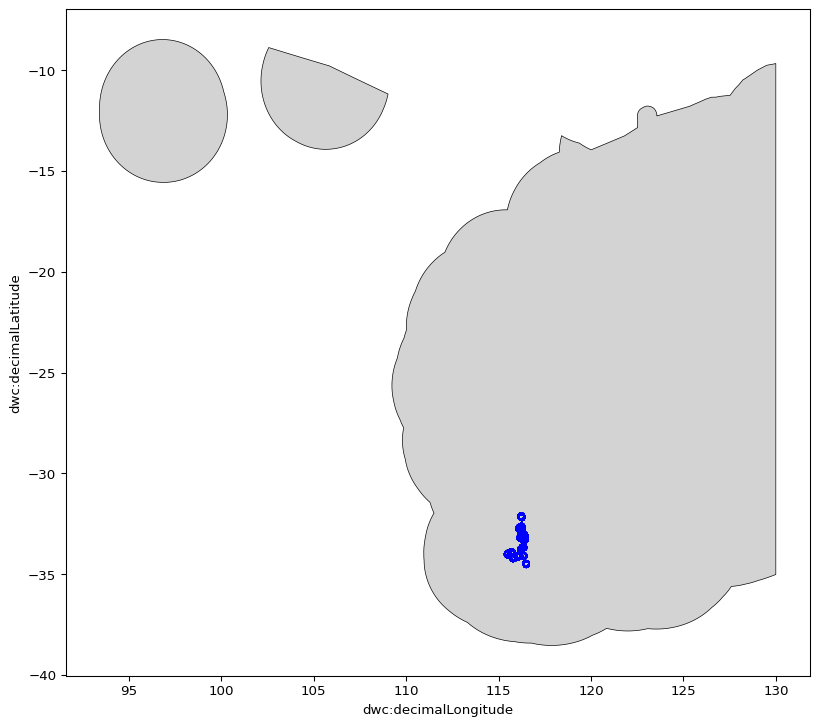

In [20]:
# visualize the coordinates.
basemap: gpd.GeoDataFrame = gpd.read_file(EEZ)
f, ax = plt.subplots(1, figsize=(10,10), dpi=96)
basemap.plot(ax=ax, color='lightgray')
extents.plot(ax=ax,cmap=None, alpha=1, edgecolor='black', color='none', linewidths=0.5)
ef.loc[lat_type_valid & lon_type_valid & loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude', y='dwc:decimalLatitude', edgecolor='blue', color='none')
#ef.loc[lat_type_valid & lon_type_valid  & ~loc_domain].plot.scatter(ax=ax, x='dwc:decimalLongitude',y='dwc:decimalLatitude', edgecolor='red', color='none')
plt.show()

Step 9) Populate errors(bio) and status(bio):
- status(bio) is either 'valid'/'invalid' 
- errors(bio) gives reason(s) for invalidation.

In [21]:
gf: pd.DataFrame = ef.copy(deep=True)
gf['errors(bio)'] = [[] for x in range(len(gf))]
gf['status(bio)'] = float('nan')

invalid_dtype: dict[str, pd.Series] = {
    'dwc:decimalLongitude': ~lon_type_valid, # not in lon_type_valid
    'dwc:decimalLatitude': ~lat_type_valid,
    'dwc:eventDate': ~date_type_valid,
    'dwc:scientificName': ~sci_type_valid}

for column, series in invalid_dtype.items():    
    gf.loc[series, 'status(bio)'] = 'INVALID'
    message: str = f'invalid dtype in column: {column}'
    gf.loc[series, 'errors(bio)'].apply(lambda x: x.append(message))

invalid_domain: dict[str, pd.Series] = {
    'location': ~loc_domain & lon_type_valid & lat_type_valid,
    'datetime': ~date_domain & date_type_valid
    }

for domain, series in invalid_domain.items():
    message: str = f'observation outside valid {domain} domain'
    gf.loc[series, 'status(bio)'] = 'INVALID'
    gf.loc[series, 'errors(bio)'].apply(lambda x: x.append(message))

message: str = f'Record contains character with umlat.'
gf.loc[umlat, 'status(bio)'] = 'INVALID'
gf.loc[umlat, 'errors(bio)'].apply(lambda x: x.append(message))

# Set status to valid on  empty 'status(bio)' column data
m: pd.Series = gf['status(bio)'].isna()
gf.loc[m, 'status(bio)'] = 'VALID'
meta: list[str] = ['status(bio)','errors(bio)']

gf = gf.loc[:, meta+dwc+verbatim+unmapped]
gf.head()

0                                                            status(bio)  \
dwc:datasetName        submission_id(bio) persistent_id(bio)               
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9         VALID   
                                          2024JTQSL144bb21         VALID   
                                          2024JTQSL1581fa0         VALID   
                                          2024JTQSL1998ebe         VALID   
                                          2024JTQSL1999143         VALID   

0                                                            errors(bio)  \
dwc:datasetName        submission_id(bio) persistent_id(bio)               
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9            []   
                                          2024JTQSL144bb21            []   
                                          2024JTQSL1581fa0            []   
                                          2024JTQSL1998ebe            []   
                                          2024JTQSL1999143            []   

0                                                             dwc:decimalLatitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                        
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9             -34.193430   
                                          2024JTQSL144bb21             -34.120472   
                                          2024JTQSL1581fa0             -33.188840   
                                          2024JTQSL1998ebe             -33.768842   
                                          2024JTQSL1999143             -33.775876   

0                                                             dwc:decimalLongitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              115.841570   
                                          2024JTQSL144bb21              116.059745   
                                          2024JTQSL1581fa0              116.170272   
                                          2024JTQSL1998ebe              116.204943   
                                          2024JTQSL1999143              116.229135   

0                                                            dwc:eventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                 
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9      2013-11-05   
                                          2024JTQSL144bb21      2001-11-21   
                                          2024JTQSL1581fa0      2002-10-30   
                                          2024JTQSL1998ebe      2014-10-28   
                                          2024JTQSL1999143      2014-10-28   

0                                                             dwc:scientificName  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                       
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9    Acanthiza apicalis   
                                          2024JTQSL144bb21    Acanthiza apicalis   
                                          2024JTQSL1581fa0    Acanthiza apicalis   
                                          2024JTQSL1998ebe    Acanthiza apicalis   
                                          2024JTQSL1999143    Acanthiza apicalis   

0                                                            dwc:verbatimEventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              2013-11-05   
                                          2024JTQSL144bb21              2001-11-21   
                                          2024JTQSL1581fa0              2002-10-30   
                                          2024JTQSL1998ebe              2014-10-28   
                                          2024JTQSL1999143              2014-10-28 

Step 10) Log summary of validation results.

In [22]:
# count invalid records.
invalid: pd.Series = (gf['status(bio)'] == 'INVALID')
invalid_count: int = len(gf.loc[invalid])

# list all reasons for invalidation, with counts.
ag: pd.DataFrame = gf.loc[invalid].copy(deep=True)
ag['errors(bio)'] = ag['errors(bio)'].apply(lambda x: str(sorted(x)))
ag: pd.DataFrame = ag.groupby(by='errors(bio)', as_index=False)['status(bio)'].count()
assert ag['status(bio)'].sum() == invalid_count

reasons: str = ag.to_string(header=False, index=False)
entry: str = f'{invalid_count} out of {len(gf)} records marked as invalid, reasons: {reasons}.'
logevent(description=entry, user=socket.gethostname(), eventlog=eventlog)

,event_id,datetime,user,description
0,2024JTQQf1950e84,2024-09-19T16:16:31.103709,Charles,"errors when reading file ""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" : N/A"
1,2024JTQSL0e00379,2024-09-19T16:18:11.057375,Charles,"""AquaticProjects/ForestCheck Data/Birds/Birds Master File.xlsx"" in container ""015-extracted-data"" tagged with: {'submission_id': '2024JTQSKe5a17d6', 'dataset': 'Birds Master File data'}"
2,2024JTQSL1a59969,2024-09-19T16:18:11.107942,Charles,"5240 uids added to column ""persistent_id(bio)""."
3,2024JTQSN66215e4,2024-09-19T16:18:13.418353,Charles,"columns ""dwc:datasetName"" and ""submission_id(bio)"" populated."
4,2024JTQSN6d1bc88,2024-09-19T16:18:13.446928,Charles,"columns remapped: {'SCIENTIFIC NAME': 'dwc:scientificName', 'DATE': 'dwc:eventDate', 'Latitude': 'dwc:decimalLatitude', 'Longitude': 'dwc:decimalLongitude'}"
5,2024JTQSN6e908cb,2024-09-19T16:18:13.452891,Charles,"verbatim fields added: {'SCIENTIFIC NAME': 'dwc:verbatimIdentification', 'DATE': 'dwc:verbatimEventDate', 'Latitude': 'dwc:verbatimLatitude', 'Longitude': 'dwc:verbatimLongitude'}"
6,2024JTQSN94169c5,2024-09-19T16:18:13.606596,Charles,number of missing string values replaced: 0.
7,2024JTQSS932959f,2024-09-19T16:18:18.602792,Charles,"0 out of 5240 records marked as invalid, reasons: Empty DataFrame\nColumns: [errors(bio), status(bio)]\nIndex: []."


Step 11) write to 025-preprocessed-data.

In [23]:
write_to_blob(gf, a25_preprocessed, targetp, index=True, timeout=12000)
tagfile(a25_preprocessed, targetp, tags)

{'submission_id': '2024JTQSKe5a17d6', 'dataset': 'Birds Master File data'}

Step 12) write log to 030-ingestion-ready

In [24]:
# write log to blob.
write_to_blob(eventlog, a30_ingestion, logpath, index=False, timeout=12000)
tagfile(a30_ingestion, logpath, tags)

{'submission_id': '2024JTQSKe5a17d6', 'dataset': 'Birds Master File data'}

Step 13) Separate valid/invalid records.

In [25]:
# Confirm the number of valid and invalid record.
v: pd.Series = (gf['status(bio)'] == 'VALID')
inval: pd.DataFrame = gf.loc[~v]
valid: pd.DataFrame = gf.loc[v]
#valid_count: int = v.sum()
invalid_count: int = (~v).sum()

#print(f'Total number of valid records: {valid_count}')
print(f'Total number of invalid records:{invalid_count}')

Total number of invalid records:0


Step 14b) Since there are no invalid records, create a file extension for the records

In [26]:
hf: pd.DataFrame = valid.copy(deep=True)
PARTCOLUMNS: list[str] = []

if len(hf) > 0:  # Checking that hf dataframe isn't empty
    if len(PARTCOLUMNS) > 0:  # If PARTCOLUMNS isn't empty
        hf['filename(bio)'] = hf.apply(lambda x: f'{partdir}/{filename}_{combine_str(x[PARTCOLUMNS]).lower()}_', axis=1)
    else:  # if it's empty
        hf['filename(bio)'] = hf.apply(lambda x: f'{partdir}/{filename}_', axis=1)
    hf.sort_values(by='filename(bio)', inplace=True)
    
    # Generate the filename by appending .csv extension
    hf['filename(bio)'] = hf.apply(lambda x: f"{x['filename(bio)']}.csv", axis=1) 
    #hf.drop(columns='part(bio)', inplace=True) # Drop the part number (part(bio)) column

hf.head()

0                                                            status(bio)  \
dwc:datasetName        submission_id(bio) persistent_id(bio)               
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9         VALID   
                                          2024JTQSL17819d6         VALID   
                                          2024JTQSL17f11cc         VALID   
                                          2024JTQSL19b8522         VALID   
                                          2024JTQSL14203f6         VALID   

0                                                            errors(bio)  \
dwc:datasetName        submission_id(bio) persistent_id(bio)               
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9            []   
                                          2024JTQSL17819d6            []   
                                          2024JTQSL17f11cc            []   
                                          2024JTQSL19b8522            []   
                                          2024JTQSL14203f6            []   

0                                                             dwc:decimalLatitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                        
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9             -34.193430   
                                          2024JTQSL17819d6             -34.211828   
                                          2024JTQSL17f11cc             -33.124856   
                                          2024JTQSL19b8522             -32.676548   
                                          2024JTQSL14203f6             -34.089222   

0                                                             dwc:decimalLongitude  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              115.841570   
                                          2024JTQSL17819d6              115.794799   
                                          2024JTQSL17f11cc              116.236673   
                                          2024JTQSL19b8522              116.276827   
                                          2024JTQSL14203f6              116.368096   

0                                                            dwc:eventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                 
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9      2013-11-05   
                                          2024JTQSL17819d6      2007-11-27   
                                          2024JTQSL17f11cc      2008-12-09   
                                          2024JTQSL19b8522      2017-10-13   
                                          2024JTQSL14203f6      2001-11-08   

0                                                                  dwc:scientificName  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                            
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9         Acanthiza apicalis   
                                          2024JTQSL17819d6    Pachycephala fuliginosa   
                                          2024JTQSL17f11cc    Pachycephala fuliginosa   
                                          2024JTQSL19b8522    Pachycephala fuliginosa   
                                          2024JTQSL14203f6    Pachycephala fuliginosa   

0                                                            dwc:verbatimEventDate  \
dwc:datasetName        submission_id(bio) persistent_id(bio)                         
Birds Master File data 2024JTQSKe5a17d6   2024JTQSL191cef9              2013-11-05   
                                          2024JTQSL17819d6              2007-11-27   
                                          2024JTQSL17f11cc              2008-12-09   
                                          2024JTQSL19b8522              2017-10-13   
                                          2024JT

Step 15) Write csv file to 030-ingestion-ready

In [28]:
jf: pd.DataFrame = hf.copy(deep=True)
if (len(jf) > 0): # Checking that jf dataframe isn't empty
    for mypath in jf['filename(bio)'].unique():
        m: pd.Series = (jf['filename(bio)'] == mypath)
        segment: pd.DataFrame = jf.loc[m].drop(columns='filename(bio)')
        write_to_blob(segment, a30_ingestion, Path(mypath), index=True, timeout=12000)
        tagfile(a30_ingestion, Path(mypath), tags)